In [11]:
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

import torchvision
from torchvision import transforms

### Autoencoder for a 4-tuple observation

In [2]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, n_hidden, lr) -> None:
        """ Initializes the AutoEncoder Network. """
        
        super().__init__()
        
        # define the encoder network
        self.encoder = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
        )
        
        # define the decoder network
        self.decoder = nn.Sequential(
            nn.Linear(n_hidden, n_features),
        )
    
        # define the optimizer
        self.optim = optim.Adam(self.parameters(), lr=lr)
    
        # define a loss function
        self.loss = nn.MSELoss()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
    def get_loss(self, x, yhat):
        return self.loss(x, yhat)

autoencoder = AutoEncoder(n_features=4, n_hidden=2, lr=0.001)

In [3]:
# create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array") # human

autoencoder_losses = []

n_episodes = 1000
for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # play one episode
    done = False
    while not done:
        
        # pass obs through the autoencoder
        x = torch.tensor(obs, dtype=torch.float32) # device
        yhat = autoencoder(x)
        
        # get a loss and update the autoencoder
        autoencoder_loss = autoencoder.get_loss(x, yhat)
        autoencoder.optim.zero_grad()
        autoencoder_loss.backward()
        autoencoder.optim.step()
        
        autoencoder_losses.append(autoencoder_loss.item())
        
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
        
        # print(next_obs)
        # env.render()
        
        done = terminated or truncated
        obs = next_obs

env.close()

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.39it/s]


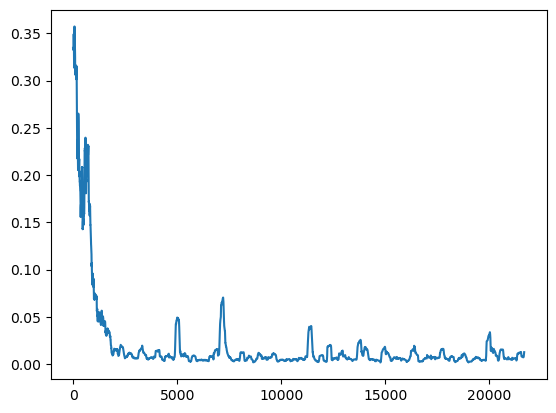

In [4]:
rolling_length = 200

autoencoder_losses_moving_average = (
    np.convolve(
        np.array(autoencoder_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)


plt.plot(autoencoder_losses_moving_average)

In [6]:
for x in autoencoder.parameters():
    print(x)

Parameter containing:
tensor([[-0.0647, -0.3602,  0.0445,  0.5262],
        [ 0.2200,  0.4598,  0.7096,  0.3452]], requires_grad=True)
Parameter containing:
tensor([1.4819, 0.3092], requires_grad=True)
Parameter containing:
tensor([[-0.1025, -0.0200],
        [-0.9483,  0.9665],
        [ 0.0604,  0.4654],
        [ 1.2495,  0.5645]], requires_grad=True)
Parameter containing:
tensor([ 0.1021,  1.1319, -0.2278, -2.0342], requires_grad=True)


### ConvAutoencoder for image observations

<div style="width: 600px; margin: auto; width: 60%;">
    <img src="conv_enc_1.png"/>
<div>

In [7]:
class ConvAutoEncoder(nn.Module):
    
    def __init__(self, in_channels, lr, dropout):
        """ Initializes the AutoEncoder Network. """
        
        super().__init__()
        
        # define the encoder network
        self.encoder = nn.Sequential(
            # 3 @ 96 x 96 -> 32 @ 96 x 96
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1, stride=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            
            # 32 @ 96 x 96 -> 32 @ 96 x 96
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            
            # 32 @ 96 x 96 -> 32 @ 47 x 47
            nn.MaxPool2d(3, stride=2),
            
            # 32 @ 47 x 47 -> 1 @ 47 x 47
            nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            
            # 1 @ 47 x 47 -> 1 @ 23 x 23
            nn.MaxPool2d(3, stride=2),
            
            # 1 @ 23 x 23 -> 32
            nn.Flatten(),
            nn.Linear(23*23, 32),
            nn.ReLU(),
        )
        
        
        # define the decoder network
        self.decoder = nn.Sequential(
            
            # 1 @ 32 -> 1 @ 23 x 23
            nn.Linear(32, 23*23),
            nn.ReLU(),
            nn.Unflatten(1, (23, 23)), # nn.Unflatten(1, (32, 4, 4)),
            
           
            # 1 @ 23 x 23 -> 16 @ 47 x 47
            nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2),
            nn.Dropout(dropout),
            nn.ReLU(),
            
            # 16 @ 47 x 47 -> 16 @ 95 x 95
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2),
            nn.Dropout(dropout),
            nn.ReLU(),
            
            # 6 @ 95 x 95 -> 3 @ 96 x 96
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=1),
            nn.ReLU(),
        )

        # define the optimizer
        self.optim = optim.Adam(self.parameters(), lr=lr)
    
        # define a loss function
        self.loss = nn.MSELoss()
    
    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        return x
    
    def get_loss(self, x, yhat):
        return self.loss(x, yhat)

autoencoder = ConvAutoEncoder(in_channels=3, lr=0.01, dropout=0.5)

In [8]:
x = torch.rand((3,96,96)) # C x H x W (permute obs)
x.shape

torch.Size([3, 96, 96])

In [9]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_trainable_parameters(autoencoder)

47525

In [10]:
autoencoder(x).shape

torch.Size([1, 32])


torch.Size([3, 96, 96])

In [60]:
env = gym.make("CarRacing-v2")
obs = env.observation_space.sample()

In [61]:
obs.shape

(96, 96, 3)

In [70]:
x = torch.tensor(obs, dtype=torch.float32)
x.shape

torch.Size([96, 96, 3])

In [71]:
x = torch.permute(x, (2, 0, 1))
x.shape

torch.Size([3, 96, 96])

In [70]:
# create the environment
env = gym.make("CarRacing-v2", render_mode="rgb_array") # human

autoencoder_losses = []

n_episodes = 50
for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # play one episode
    done = False
    while not done:
        
        # pass obs through the autoencoder
        x = torch.tensor(obs, dtype=torch.float32) # device
        x = torch.permute(x, (2, 0, 1)) # HxWxC -> CxHxW
        yhat = autoencoder(x)
        
        # get a loss and update the autoencoder
        autoencoder_loss = autoencoder.get_loss(x, yhat)
        autoencoder.optim.zero_grad()
        autoencoder_loss.backward()
        autoencoder.optim.step()
        
        autoencoder_losses.append(autoencoder_loss.item())
        
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
        
        # print(next_obs)
        # env.render()
        
        done = terminated or truncated
        obs = next_obs

env.close()

  0%|                                                                                                    | 0/50 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (288x96 and 4x2)

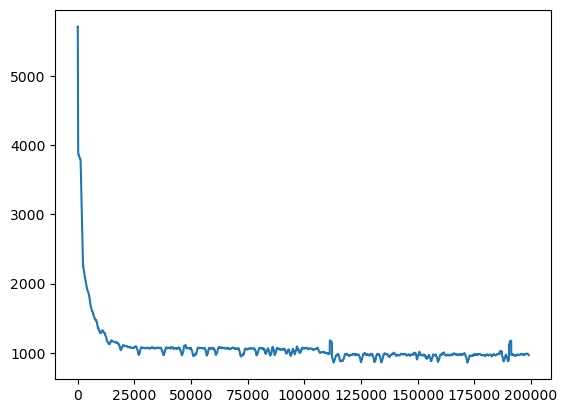

In [260]:
rolling_length = 1000

autoencoder_losses_moving_average = (
    np.convolve(
        np.array(autoencoder_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)


plt.plot(autoencoder_losses_moving_average)

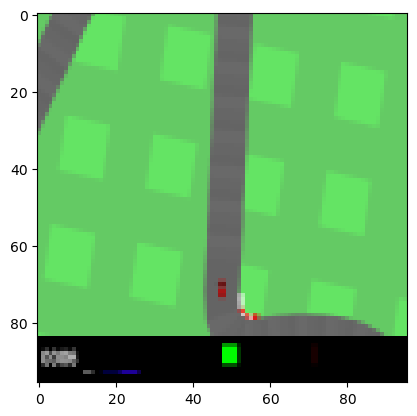

In [7]:
env = gym.make("CarRacing-v2", render_mode="rgb_array")

obs, info = env.reset()
for i in range(20):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
plt.imshow(obs)


In [8]:
obs

array([[[100, 202, 100],
        [100, 202, 100],
        [100, 202, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 202, 100],
        [100, 202, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 202, 100],
        [100, 187, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

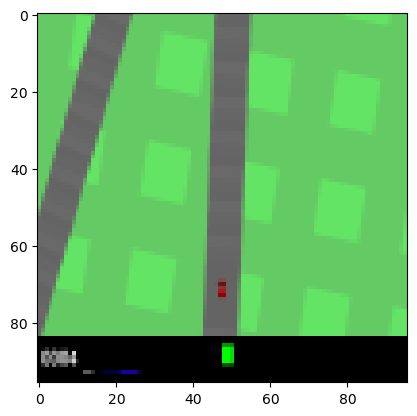

In [266]:
env = gym.make("CarRacing-v2", render_mode="rgb_array")

obs, info = env.reset()
for i in range(20):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
plt.imshow(obs)

x = torch.tensor(obs, dtype=torch.float32) # device
xp = torch.permute(x, (2, 0, 1)) # HxWxC -> CxHxW

yhat = autoencoder(xp)
yhat = torch.permute(yhat, (1,2,0))
yhat = yhat.detach().numpy()

env.close()

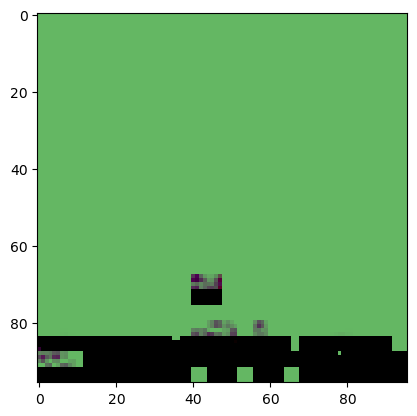

In [267]:
plt.imshow(torch.tensor(yhat, dtype=torch.long))

### Test area

In [ ]:
x = torch.tensor(np.random.rand(4), dtype=torch.float32) # device

In [ ]:
yhat = autoencoder(x)

In [ ]:
x

In [ ]:
yhat

In [ ]:
autoencoder.get_loss(x, yhat)

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

obs, info = env.reset()
x = torch.tensor(obs, dtype=torch.float32) # device
yhat = autoencoder(x)

print("input:", x)
print("reconstruction:", yhat)

env.close()

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
env.close()

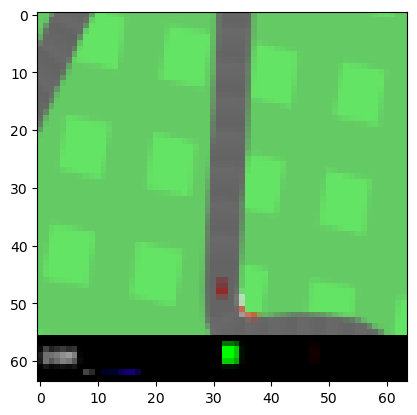

In [68]:
# Preprocessing

""" transformation: scale pixel values and resize the shape """
transform = transforms.Compose([
    transforms.ToTensor(), # -> scaled to [0,1]
    transforms.Resize((64, 64)), # 3x64x64
])

img = transform(obs)
plt.imshow(img.permute(1, 2, 0)) # show the transformed img

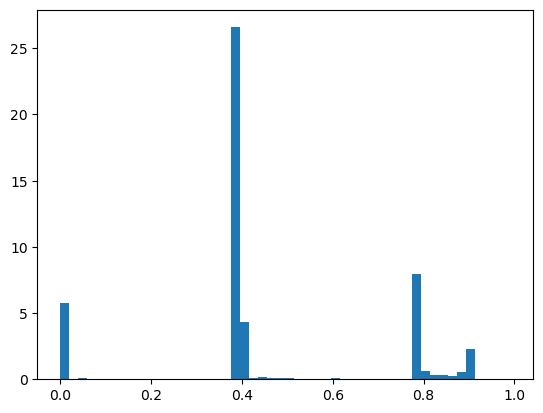

In [67]:
# show the distribution of scaled pixel values
plt.hist(torch.ravel(img).numpy(), bins=50, density=True);